<a href="https://colab.research.google.com/github/nv-hiep/Autoencoders/blob/main/Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Reshape, Input
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Dropout, ActivityRegularization
from keras.layers import LSTM, RepeatVector, TimeDistributed, GaussianNoise

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    # plt.axis('off')

# Data

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train_full = X_train_full / 255.
X_test       = X_test / 255.

In [ ]:
print('X_train_full.shape: ', X_train_full.shape)
print('y_train_full.shape: ', y_train_full.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train_full.shape:  (60000, 28, 28)
y_train_full.shape:  (60000,)
X_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


In [ ]:
train_size = 50_000

In [ ]:
X_train = X_train_full[:train_size]
X_valid = X_train_full[train_size:]

y_train = y_train_full[:train_size]
y_valid = y_train_full[train_size:]

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_valid.shape: ', X_valid.shape)
print('y_valid.shape: ', y_valid.shape)

X_train.shape:  (50000, 28, 28)
y_train.shape:  (50000,)
X_valid.shape:  (10000, 28, 28)
y_valid.shape:  (10000,)


In [ ]:
def show_reconstructions(model, images=X_test, n_images=5):
  '''
  First row: real images
  Second row: reconstructed images
  '''
  reconstructions = model.predict(images[:n_images])

  plt.figure(figsize=(n_images * 1.5, 3))
  # plt.title('Image reconstruction from Stacked Autoencoder')
  for img_id in range(n_images):
    plt.subplot(2, n_images, 1 + img_id)
    plot_image(images[img_id])
    plt.subplot(2, n_images, 1 + n_images + img_id)
    plot_image(reconstructions[img_id])
  plt.show()

Let's create a couple functions to print nice activation histograms:

In [ ]:
def plot_percent_hist(ax, data, bins):
  counts, _ = np.histogram(data, bins=bins)
  widths = bins[1:] - bins[:-1]
  x = bins[:-1] + widths / 2
  ax.bar(x, counts / len(data), width=widths*0.8)
  ax.xaxis.set_ticks(bins)
  ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, position: "{}%".format(int(np.round(100 * y)))))
  ax.grid(True)

In [ ]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
  X_valid_codings = encoder(X_valid).numpy()
  activation_means = X_valid_codings.mean(axis=0)
  mean = activation_means.mean()
  bins = np.linspace(0, 1, n_bins + 1)

  fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
  plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
  ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
  ax1.legend(loc="upper center", fontsize=14)
  ax1.set_xlabel("Activation")
  ax1.set_ylabel("% Activations")
  ax1.axis([0, 1, 0, height])
  plot_percent_hist(ax2, activation_means, bins)
  ax2.plot([mean, mean], [0, height], "k--")
  ax2.set_xlabel("Neuron Mean Activation")
  ax2.set_ylabel("% Neurons")
  ax2.axis([0, 1, 0, height])

# Variational Autoencoder

Another important category of autoencoders was introduced in 2013 by Diederik Kingma and Max Welling and quickly became one of the most popular types of autoencoders: variational autoencoders.

They are quite different from all the autoencoders we have discussed so far, in these particular ways:

- They are probabilistic autoencoders, meaning that their outputs are partly determined by chance, even after training (as opposed to denoising autoencoders, which use randomness only during training).

- Most importantly, they are generative autoencoders, meaning that they can generate new instances that look like they were sampled from the training set.

Both these properties make them rather similar to RBMs, but they are easier to train, and the sampling process is much faster (with RBMs you need to wait for the network to stabilize into a “thermal equilibrium” before you can sample a new instance). Indeed, as their name suggests, variational autoencoders perform variational Bayesian inference, which is an efficient way to perform approximate Bayesian inference.

Let’s start building a variational autoencoder for Fashion MNIST. First, we will need a custom layer to sample the codings, given μ and γ:

In [ ]:
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = Input(shape=[28, 28])
z = Flatten()(inputs)
z = Dense(150, activation="selu")(z)
z = Dense(100, activation="selu")(z)
codings_mean = Dense(codings_size)(z)
codings_log_var = Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(100, activation="selu")(decoder_inputs)
x = Dense(150, activation="selu")(x)
x = Dense(28 * 28, activation="sigmoid")(x)
outputs = Reshape([28, 28])(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)

variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_accuracy'])

In [ ]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_valid, X_valid))

Epoch 1/25
391/391 [==============================] - 5s 7ms/step - loss: 0.4484 - binary_accuracy: 0.4794 - val_loss: 0.3633 - val_binary_accuracy: 0.5014
Epoch 2/25
391/391 [==============================] - 2s 5ms/step - loss: 0.3487 - binary_accuracy: 0.5028 - val_loss: 0.3367 - val_binary_accuracy: 0.5001
Epoch 3/25
391/391 [==============================] - 2s 5ms/step - loss: 0.3356 - binary_accuracy: 0.5048 - val_loss: 0.3429 - val_binary_accuracy: 0.5034
Epoch 4/25
391/391 [==============================] - 2s 6ms/step - loss: 0.3293 - binary_accuracy: 0.5059 - val_loss: 0.3285 - val_binary_accuracy: 0.5024
Epoch 5/25
391/391 [==============================] - 2s 5ms/step - loss: 0.3265 - binary_accuracy: 0.5053 - val_loss: 0.3299 - val_binary_accuracy: 0.5015
Epoch 6/25
391/391 [==============================] - 2s 6ms/step - loss: 0.3235 - binary_accuracy: 0.5060 - val_loss: 0.3241 - val_binary_accuracy: 0.5030
Epoch 7/25
391/391 [==============================] - 2s 6ms/ste

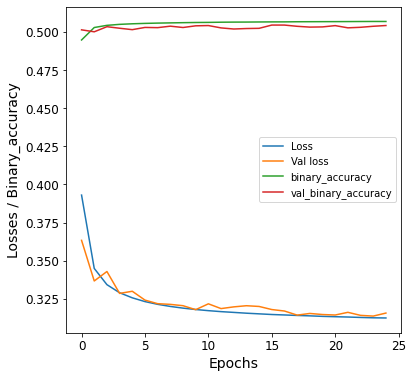

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

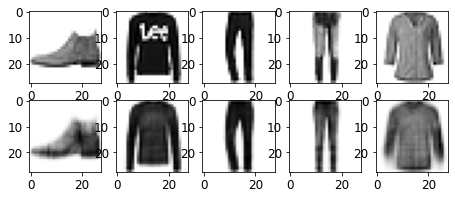

In [ ]:
# Plot the reconstructed images
show_reconstructions(variational_ae, images=X_test)
plt.show()

# Generating Fashion MNIST Images

Now let’s use this variational autoencoder to generate images that look like fashion items. All we need to do is sample random codings from a Gaussian distribution and decode them:

In [ ]:
def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  
  plt.figure(figsize=(n_cols, n_rows))
  
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

Let's generate a few random codings, decode them and plot the resulting images:

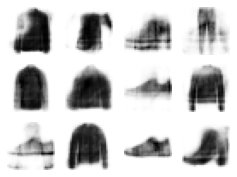

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

Now let's perform semantic interpolation between these images:

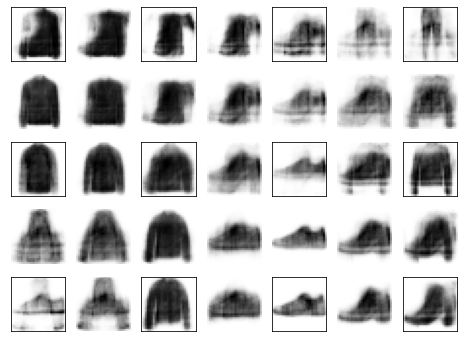

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(8, 6))
for index, image in enumerate(images):
  plt.subplot(5, 7, index + 1)
  if index%7%2==0 and index//7%2==0:
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
  else:
    plt.axis('off')
  
  plt.imshow(image, cmap='binary')
plt.show()  

The original images are framed, and the rest are the result of semantic interpolation between the nearby images. Notice, for example, how the shoe in the fourth row and fifth column is a nice interpolation between the two shoes located above and below it.